<a href="https://colab.research.google.com/github/Photometry4040/Diabetes-Self-Assessment-Checklist/blob/main/%EC%8B%A0%EB%AC%B8%EA%B8%B0%EC%82%AC%ED%81%AC%EB%A1%A4%EB%A7%81.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install selenium



In [ ]:
!pip install webdriver-manager
!apt-get update
!apt-get install -y wget unzip
!wget https://dl.google.com/linux/direct/google-chrome-stable_current_amd64.deb
!dpkg -i google-chrome-stable_current_amd64.deb
!apt-get -f install -y
!apt-get install -y google-chrome-stable
!wget -N https://chromedriver.storage.googleapis.com/113.0.5672.63/chromedriver_linux64.zip
!unzip -q chromedriver_linux64.zip
!mv chromedriver /usr/local/bin/



Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Ign:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Get:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:8 https://r2u.stat.illinois.edu/ubuntu jammy Release [5,713 B]
Get:9 https://r2u.stat.illinois.edu/ubuntu jammy Release.gpg [793 B]
Hit:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:11 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [945 kB]
Get:12 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease [24.3 kB]
Get:13 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 P

In [ ]:
!chmod +x /usr/local/bin/chromedriver

In [ ]:
import time
import requests
from bs4 import BeautifulSoup
import pandas as pd
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from webdriver_manager.chrome import ChromeDriverManager
from html import unescape
from datetime import datetime

# Pandas 옵션 설정: 긴 문자열도 모두 출력되도록 설정
pd.set_option('display.max_colwidth', None)

# 키워드를 입력하세요
keyword = "테슬라"

# 조회 기간 옵션 설정
print("조회 기간을 선택하세요:")
print("1: 전체 기간")
print("2: 최근 1일")
print("3: 최근 1주")
print("4: 최근 1개월")
print("5: 최근 3개월")
print("6: 최근 6개월")
print("7: 최근 1년")

period_selection = input("선택: ")

# 조회 기간에 따른 pd 및 nso 파라미터 설정
if period_selection == "1":
    pd_param = "0"
    nso_param = "so:dd,p:all"
elif period_selection == "2":
    pd_param = "4"
    nso_param = "so:dd,p:1d"
elif period_selection == "3":
    pd_param = "1"
    nso_param = "so:dd,p:1w"
elif period_selection == "4":
    pd_param = "2"
    nso_param = "so:dd,p:1m"
elif period_selection == "5":
    pd_param = "3"
    nso_param = "so:dd,p:3m"
elif period_selection == "6":
    pd_param = "6"
    nso_param = "so:dd,p:6m"
elif period_selection == "7":
    pd_param = "5"
    nso_param = "so:dd,p:1y"
else:
    print("올바른 옵션을 선택하세요.")
    exit()

# 네이버 뉴스 검색 결과 URL
url = f"https://search.naver.com/search.naver?where=news&query={keyword}&sm=tab_opt&sort=1&photo=0&field=0&pd={pd_param}&ds=&de=&docid=&related=0&mynews=0&office_type=0&office_section_code=0&news_office_checked=&nso={nso_param}&is_sug_officeid=0&office_category=0&service_area=0"

# Selenium WebDriver 설정 (헤드리스 모드)
chrome_options = Options()
chrome_options.add_argument("--headless")  # GUI 없는 모드에서 실행
chrome_options.add_argument("--no-sandbox")
chrome_options.add_argument("--disable-dev-shm-usage")

driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=chrome_options)
driver.get(url)

# 현재 날짜 (조회날짜) 가져오기
current_date = datetime.now().strftime('%Y-%m-%d')

# 기사 데이터 크롤링
data = []

# 페이지 스크롤 반복 횟수 설정
max_scrolls = 100  # 이 값을 조정하여 스크롤을 더 많이 하거나 적게 할 수 있습니다.
scroll_pause_time = 1  # 스크롤 후 대기 시간
screen_height = driver.execute_script("return window.screen.height;")  # 화면 높이 가져오기

for scroll in range(max_scrolls):
    # 스크롤하기
    driver.execute_script(f"window.scrollTo(0, {screen_height}*{scroll});")
    time.sleep(scroll_pause_time)

    # 페이지 소스를 가져와서 BeautifulSoup으로 파싱
    soup = BeautifulSoup(driver.page_source, 'html.parser')

    # 기사 수 계산 및 출력
    articles = soup.find_all('div', class_='news_area')
    print(f"스크롤 횟수 {scroll + 1}: 현재까지 {len(articles)}개의 기사를 발견했습니다.")

    # 현재까지 로드된 기사의 정보 크롤링
    for article in articles:
        title_tag = article.find('a', class_='news_tit')
        title = title_tag['title'].strip() if title_tag else "제목 없음"
        link = title_tag['href'] if title_tag else "링크 없음"

        # HTML 엔티티와 태그 제거
        title = unescape(title)  # HTML 엔티티 해제
        title = BeautifulSoup(title, 'html.parser').get_text()  # HTML 태그 제거

        # 신문사 이름 추출
        press_tag = article.find('a', class_='info press')
        press = "신문사 정보 없음"
        if press_tag:
            thumb_box = press_tag.find('span', class_='thumb_box')
            if thumb_box:
                press = thumb_box.next_sibling.strip() if thumb_box.next_sibling else "신문사 정보 없음"
            else:
                press = press_tag.get_text(strip=True)

        # 발행일 추출 (class='info'인 <span> 태그)
        pub_date = "발행일 없음"
        pub_date_tag = article.find('span', class_='info')
        if pub_date_tag and "전" in pub_date_tag.get_text():
            pub_date = pub_date_tag.get_text(strip=True)

        # 디버그: 정보 누락 시 출력
        if press == "신문사 정보 없음" or pub_date == "발행일 없음":
            print(f"누락된 정보가 있습니다 - 제목: {title}, 링크: {link}")

        # '바로가기' 링크 생성
        link_html = f'<a href="{link}" target="_blank">바로가기</a>'

        # 데이터 저장
        data.append({
            '조회날짜': current_date,
            '제목': title,
            '신문사': press,
            '발행일': pub_date,
            '링크': link_html
        })

    # 더 이상 새로운 기사가 없다면 종료
    if len(articles) >= 50:  # 예시로 50개 이상의 기사를 크롤링한 경우 종료
        print(f"총 {len(articles)}개의 기사를 모두 로드했습니다.")
        break

# 데이터 프레임으로 변환
df = pd.DataFrame(data)

# DataFrame을 HTML로 변환하여 링크가 포함된 형식으로 출력
df_html = df.to_html(escape=False)  # HTML 코드가 이스케이프되지 않도록 설정

# Jupyter Notebook에서 HTML로 출력
from IPython.core.display import display, HTML
display(HTML(df_html))

# 브라우저 종료
driver.quit()


조회 기간을 선택하세요:
1: 전체 기간
2: 최근 1일
3: 최근 1주
4: 최근 1개월
5: 최근 3개월
6: 최근 6개월
7: 최근 1년
선택: 3
스크롤 횟수 1: 현재까지 10개의 기사를 발견했습니다.
누락된 정보가 있습니다 - 제목: [만물상] 원전 거인 ‘웨스팅하우스’의 추락, 링크: https://www.chosun.com/opinion/manmulsang/2024/08/25/NNAFAAD4WBAU3GZOVGWJJCJNKQ/?utm_source=naver&utm_medium=referral&utm_campaign=naver-news
누락된 정보가 있습니다 - 제목: 美 9월 금리 인하 확실시… 한은, 언제쯤 내릴까, 링크: http://www.segye.com/newsView/20240825508636?OutUrl=naver
스크롤 횟수 2: 현재까지 10개의 기사를 발견했습니다.
누락된 정보가 있습니다 - 제목: [만물상] 원전 거인 ‘웨스팅하우스’의 추락, 링크: https://www.chosun.com/opinion/manmulsang/2024/08/25/NNAFAAD4WBAU3GZOVGWJJCJNKQ/?utm_source=naver&utm_medium=referral&utm_campaign=naver-news
누락된 정보가 있습니다 - 제목: 美 9월 금리 인하 확실시… 한은, 언제쯤 내릴까, 링크: http://www.segye.com/newsView/20240825508636?OutUrl=naver
스크롤 횟수 3: 현재까지 10개의 기사를 발견했습니다.
누락된 정보가 있습니다 - 제목: [만물상] 원전 거인 ‘웨스팅하우스’의 추락, 링크: https://www.chosun.com/opinion/manmulsang/2024/08/25/NNAFAAD4WBAU3GZOVGWJJCJNKQ/?utm_source=naver&utm_medium=referral&utm_campaign=naver-news
누락된 정보가 있습니다 - 제목: 美 9월 금

,조회날짜,제목,신문사,발행일,링크
0,2024-08-25,[만물상] 원전 거인 ‘웨스팅하우스’의 추락,조선일보,발행일 없음,바로가기
1,2024-08-25,"아이오닉 5 N, 올해의전기차 선정",울산신문,37분 전,바로가기
2,2024-08-25,"美 9월 금리 인하 확실시… 한은, 언제쯤 내릴까",세계일보,발행일 없음,바로가기
3,2024-08-25,"현대차 아이오닉 5 N, 美 카앤드라이버 '2024 올해의 전기차' 선정",포인트데일리,1시간 전,바로가기
4,2024-08-25,[IRA 2년] 미국에 집중한 K-전기차…트럼프 리스크에 긴장,글로벌이코노믹,1시간 전,바로가기
5,2024-08-25,"[IRA 2년] ""美 시장 내 영향력 더 높아진 韓 완성차·배터리""",글로벌이코노믹,1시간 전,바로가기
6,2024-08-25,"두로프, 러시아 검열에 반발해 텔레그램 제작…머스크 ‘석방’ 촉구",동아일보,1시간 전,바로가기
7,2024-08-25,텔레그램 창업자 프랑스서 체포…“범죄 방치”,채널A,1시간 전,바로가기
8,2024-08-25,미국 車전문지 선정 올해의 전기차에 현대 아이오닉5N,아시아경제,1시간 전,바로가기
9,2024-08-25,"현대차 아이오닉 5 N, 카앤드라이버 '2024 올해의 전기차' 선정 쾌거",청년일보,2시간 전,바로가기


In [118]:
import urllib.request
import json
import pandas as pd
from google.colab import userdata
from google.colab import files

# 네이버 API 클라이언트 정보 (보안 비밀에서 가져오기)
client_id = userdata.get('naver_client_id')
client_secret = userdata.get('naver_client_secret')

# 사용자로부터 검색어 입력 받기
query = input("검색어를 입력하세요: ")
encText = urllib.parse.quote(query)

# 검색 결과를 저장할 리스트 초기화
all_items = []

# 1000개의 검색 결과를 100개씩 10번 반복하여 가져오기
for start in range(1, 1001, 100):
    url = f"https://openapi.naver.com/v1/search/news?query={encText}&display=100&start={start}&sort=date"

    # API 요청
    request = urllib.request.Request(url)
    request.add_header("X-Naver-Client-Id", client_id)
    request.add_header("X-Naver-Client-Secret", client_secret)

    # API 응답 받기
    response = urllib.request.urlopen(request)
    rescode = response.getcode()

    if rescode == 200:
        response_body = response.read()
        response_json = json.loads(response_body.decode('utf-8'))

        # 각 페이지의 검색 결과를 리스트에 추가
        items = response_json['items']
        all_items.extend(items)
    else:
        print("Error Code:" + str(rescode))
        break

# 모든 검색 결과를 DataFrame으로 변환
df = pd.DataFrame(all_items)

# 불필요한 HTML 태그 제거
df['title'] = df['title'].str.replace('<[^<]+?>', '', regex=True)
df['description'] = df['description'].str.replace('<[^<]+?>', '', regex=True)

# 데이터프레임 출력
print(df.head())

# CSV 파일로 저장
csv_filename = f"{query}_news_data.csv"
df.to_csv(csv_filename, index=False, encoding='utf-8-sig')
print(f"검색 결과가 '{csv_filename}' 파일로 저장되었습니다.")

# CSV 파일을 로컬 컴퓨터로 다운로드
#from google.colab import files
#files.download(csv_filename)


검색어를 입력하세요: 테슬라
                                          title  \
0  [코인시장은 지금] 비트코인 강세 전망 이어져...텔레그램 톤, 대표 체포...   
1                      [만물상] 원전 거인 ‘웨스팅하우스’의 추락   
2                           아이오닉 5 N, 올해의전기차 선정   
3                   美 9월 금리 인하 확실시… 한은, 언제쯤 내릴까   
4      현대차 아이오닉 5 N, 美 카앤드라이버 '2024 올해의 전기차' 선정   

                                                                                                                                    originallink  \
0                                                                                 http://www.biztribune.co.kr/news/articleView.html?idxno=319516   
1  https://www.chosun.com/opinion/manmulsang/2024/08/25/NNAFAAD4WBAU3GZOVGWJJCJNKQ/?utm_source=naver&utm_medium=referral&utm_campaign=naver-news   
2                                                                                  https://www.ulsanpress.net/news/articleView.html?idxno=534372   
3                                                                                    

In [100]:
from urllib.parse import urlparse
import pandas as pd

# 'originallink'에서 도메인 추출
def extract_domain(link):
    parsed_uri = urlparse(link)
    domain = '{uri.netloc}'.format(uri=parsed_uri).replace("www.", "")
    return domain

# 도메인과 신문사 이름 매핑 테이블
domain_to_press = {
    "chosun.com": "조선일보",
    "ulsanpress.net": "울산신문",
    "segye.com": "세계일보",
    "pointdaily.co.kr": "포인트데일리",
    "g-enews.com": "글로벌이코노믹",
    "donga.com": "동아일보",
    "ichannela.com": "채널A",
    "view.asiae.co.kr": "아시아경제",
    "youthdaily.co.kr": "유스데일리",
    "kmib.co.kr": "국민일보",
    "hankyung.com": "한국경제",
    "dt.co.kr": "디지털타임스",
    "pinpointnews.co.kr": "핀포인트뉴스",
    "mk.co.kr": "매일경제",
    "yonhapnewstv.co.kr": "연합뉴스TV",
    "sedaily.com": "서울경제",
    "imaeil.com": "매일신문",
    "businesspost.co.kr": "비즈니스포스트",
    "hankookilbo.com": "한국일보",
    "jnilbo.com": "전남일보",
    "fetv.co.kr": "FETV",
    "idsn.co.kr": "IDSN",
    "hani.co.kr": "한겨레",
    "skyedaily.com": "스카이데일리",
    "etoday.co.kr": "이투데이",
    "smarttoday.co.kr": "스마트투데이",
    "autodaily.co.kr": "오토데일리",
    "edaily.co.kr": "이데일리",
    "coinreaders.com": "코인리더스",
    "m-i.kr": "매일일보",
    "kukinews.com": "쿠키뉴스",
    "thepowernews.co.kr": "더파워뉴스",
    "shinailbo.co.kr": "신아일보",
    "fnnews.com": "파이낸셜뉴스",
    "sports.chosun.com": "스포츠조선",
    "seoultimes.news": "서울타임스",
    "news1.kr": "뉴스1",
    "newsian.co.kr": "뉴스아이언",
    "news.heraldcorp.com": "헤럴드경제",
    "newslock.co.kr": "뉴스락",
    "munhwa.com": "문화일보",
    "metroseoul.co.kr": "메트로신문",
    "ajunews.com": "아주경제",
    "wowtv.co.kr": "한국경제TV",
    "thebigdata.co.kr": "빅데이터뉴스",
    "yna.co.kr": "연합뉴스",
    "theviewers.co.kr": "뷰어스",
    "khan.co.kr": "경향신문",
    "biztribune.co.kr": "비즈트리뷴",
    "news.mtn.co.kr": "MTN",
    "socialvalue.kr": "소셜밸류",
    "polinews.co.kr": "폴리뉴스",
    "bloter.net": "블로터",
    "dailian.co.kr": "데일리안",
    "paxetv.com": "팍스넷",
    "thedrive.co.kr": "더드라이브",
    "asiatoday.co.kr": "아시아투데이",
    "smedaily.co.kr": "중소기업신문",
    "newsway.co.kr": "뉴스웨이",
    "viva100.com": "브릿지경제",
    "nocutnews.co.kr": "노컷뉴스",
    "4th.kr": "사람과사회",
    "ekn.kr": "에너지경제신문",
    "betanews.net": "베타뉴스",
    "etnews.com": "전자신문",
    "ddaily.co.kr": "디지털데일리",
    "businessplus.kr": "비즈니스플러스",
    "news.sbs.co.kr": "SBS 뉴스",
    "gpkorea.com": "게임포커스",
    "worktoday.co.kr": "워크투데이",
    "ggilbo.com": "금강일보",
    "goodkyung.com": "굿경남신문",
    "financialpost.co.kr": "파이낸셜포스트",
    "dnews.co.kr": "디지털뉴스",
    "econonews.co.kr": "이코노뉴스",
    "ftoday.co.kr": "파이낸셜투데이",
    "sentv.co.kr": "서울경제TV",
    "mediapen.com": "미디어펜",
    "osen.co.kr": "OSEN",
    "economist.co.kr": "이코노미스트",
    "biz.newdaily.co.kr": "비즈뉴데일리",
    "ebn.co.kr": "EBN",
    "weekly.hankooki.com": "주간한국",
    "news.tf.co.kr": "더팩트",
    "newspim.com": "뉴스핌",
    "newsis.com": "뉴시스",
    "moneys.co.kr": "머니S",
    "zdnet.co.kr": "지디넷코리아",
    "magazine.hankyung.com": "한경매거진",
    "theguru.co.kr": "더구루",
    "fnnews.com": "파이낸셜뉴스",
    "astronomer.rocks": "천문학자들",
    "mbn.co.kr": "MBN",
    "ilyo.co.kr": "일요신문",
    "asiaa.co.kr": "아시아경제신문",
    "sisajournal.com": "시사저널",
    "news.jtbc.co.kr": "JTBC 뉴스",
    "imnews.imbc.com": "MBC 뉴스",
    "gokorea.kr": "고코리아",
    "news.dealsitetv.com": "딜사이트",
    "pennmike.com": "펜앤드마이크",
    "hansbiz.co.kr": "한스경제",
    "fortunekorea.co.kr": "포춘코리아",
    "sisajournal-e.com": "시사저널e",
    "woman.donga.com": "여성동아",
    "weekly.donga.com": "주간동아",
    "tfmedia.co.kr": "TF미디어",
    "busan.com": "부산일보",
    "news.einfomax.co.kr": "연합인포맥스",
    "ytn.co.kr": "YTN",
    "opinionnews.co.kr": "오피니언뉴스",
    "topstarnews.net": "탑스타뉴스",
    "smedaily.co.kr": "중소기업뉴스",
    "choicenews.co.kr": "초이스경제",
    "straightnews.co.kr": "스트레이트뉴스",
    "womennews.co.kr": "여성신문",
    "joseilbo.com": "조세일보",
    "lecturernews.com": "강사신문",
    "newsworks.co.kr": "뉴스웍스",
    "joongang.co.kr": "중앙일보",
    "newsclaim.co.kr": "뉴스클레임",
    "newstomato.com": "뉴스토마토",
    "wikitree.co.kr": "위키트리",
    "pressman.kr": "프레스맨",
    "nownews.seoul.co.kr": "서울신문",
    "e2news.com": "이투뉴스",
    "radiokorea.com": "라디오코리아",
    "science.ytn.co.kr": "사이언스YTN",
    "foodneconomy.com": "푸드앤경제",
    "wikileaks-kr.org": "위키리크스한국",
    "viewsnnews.com": "뷰스앤뉴스",
    "datanet.co.kr": "데이터넷",
    "datasom.co.kr": "데이터솜",
    "whitepaper.co.kr": "화이트페이퍼",
    "hellodd.com": "HelloDD",
    "nongaek.com": "농객",
    "jbnews.com": "중부매일",
    "ablenews.co.kr": "에이블뉴스",
    "mediatoday.co.kr": "미디어오늘",
    "mediajeju.com": "미디어제주",
    "ccnnews.co.kr": "충청뉴스",
    "kidd.co.kr": "대한건축사협회",
    "autotimes.co.kr": "오토타임즈",
    "irobotnews.com": "로봇신문사",
    "epj.co.kr": "전기저널",
    "thelec.kr": "더일렉",
    "4th.kr": "사람과사회",
    "ceoscoredaily.com": "CEO스코어데일리",
    "thedailypost.kr": "더데일리포스트",
    "hellot.net": "헬로티",
    "kdfnews.com": "KDF뉴스",
    "kpinews.kr": "KP뉴스",
    "yeongnam.com": "영남일보",
    "dailycar.co.kr": "데일리카",
    "seoul.co.kr": "서울신문",
    "fntimes.com": "파이낸셜타임즈",
    "naeil.com": "내일신문",
    "chungnamilbo.co.kr": "충남일보",
    "jeonmae.co.kr": "전매일보",
    "kids.donga.com": "어린이동아",
    "insight.co.kr": "인사이트",
    "cwn.kr": "충청넷",
    "public25.com": "공무원닷컴",
    "newsbbsi.co.kr": "BBS뉴스",
    "iminju.net": "민주신문",
    "newsinside.kr": "뉴스인사이드",
    "aitimes.com": "AI타임스",
    "weeklytrade.co.kr": "위클리트레이드",
    "vop.co.kr": "민중의소리",
    "koreatimes.com": "코리아타임즈",
    "ftimes.kr": "포춘타임즈",
    "womaneconomy.co.kr": "여성경제신문",
    "dizzotv.com": "디지틀조선TV",
    "sportsseoul.com": "스포츠서울",
    "newsfreezone.co.kr": "뉴스프리존",
    "newstree.kr": "뉴스트리",
    "newsworker.co.kr": "뉴스워커",
    "dailypop.kr": "데일리팝",
    "chungnamilbo.co.kr": "충남일보",
    "lawissue.co.kr": "로이슈",
    "knnews.co.kr": "경남신문",
    "kdpress.co.kr": "KDP뉴스",
    "segyebiz.com": "세계비즈",
    "itbiznews.com": "IT비즈뉴스",
    "ntoday.co.kr": "엔투데이",
    "boannews.com": "보안뉴스",
    "imnews.imbc.com": "MBC 뉴스",
    "tokenpost.kr": "토큰포스트",
    "pointe.co.kr": "포인트에이트",
    "widedaily.com": "와이드데일리",
    "thebell.co.kr": "더벨",
    "goodnews1.com": "굿뉴스1",
    "dgmbc.com": "대구MBC",
    "lcnews.co.kr": "에너지경제뉴스",
    "spotvnews.co.kr": "스포티비뉴스",
    "safetimes.co.kr": "세이프타임즈",
    "mhnse.com": "문화뉴스",
    "stoo.com": "스포츠투데이",
    "seoulfn.com": "서울파이낸스",
    "chosun.com": "조선일보",
    # 매핑되지 않은 도메인을 추가
    "news.mt.co.kr": "머니투데이",
    "biz.chosun.com": "조선비즈",
    "betanews.net:8080": "베타뉴스",
    "kpenews.com": "한국정책신문",
    "biz.sbs.co.kr": "SBS Biz",
    "it.chosun.com": "IT 조선",
    "news.tvchosun.com": "TV조선",
    "asiatime.co.kr": "아시아타임즈",
    "newsprime.co.kr": "프라임경제",
    "econovill.com": "이코노빌",
    "digitaltoday.co.kr": "디지털투데이",
    "mbn.mk.co.kr": "MBN",
    "globalepic.co.kr": "글로벌에픽",
    "apnews.kr": "AP뉴스코리아",
    "industrynews.co.kr": "산업뉴스",
    "electimes.com": "전기신문",
    "insightkorea.co.kr": "인사이트코리아",
    "energy-news.co.kr": "에너지데일리",
    "ifs.or.kr": "정책브리핑",
    "sisaon.co.kr": "시사오늘",
    "ltn.kr": "라이프타임뉴스",
    "khgames.co.kr": "경향게임스",
    "mhns.co.kr": "문화뉴스",
    "newdaily.co.kr": "뉴데일리",
    "ziksir.com": "지식인뉴스",
    "mydaily.co.kr": "마이데일리",
    "newsdream.kr": "뉴스드림",
    "psnews.co.kr": "PS뉴스",
    "newswhoplus.com": "뉴스후플러스",
    "newsquest.co.kr": "뉴스퀘스트",
    "weekly.cnbnews.com": "CNB뉴스 주간판",
    "kbench.com": "케이벤치",
    "fntoday.co.kr": "파이낸스투데이",
    "news2day.co.kr": "뉴스투데이",
    "srtimes.kr": "SR타임스",
    "dongascience.com": "동아사이언스",
    "delighti.co.kr": "디라이트아이",
    "queen.co.kr": "퀸",
    "seoulwire.com": "서울와이어",
    "cstimes.com": "컨슈머타임스",
    "newsroad.co.kr": "뉴스로드",
    "isplus.com": "일간스포츠",
    "enewstoday.co.kr": "이뉴스투데이",
    "issuenbiz.com": "이슈앤비즈",
    "getnews.co.kr": "겟뉴스",
    "wemakenews.co.kr": "위메이크뉴스",
    "obsnews.co.kr": "OBS",
    "ktnews.com": "한국섬유신문",
    "todaykorea.co.kr": "투데이코리아",
    "popcornnews.net": "팝콘뉴스",
    "joongboo.com": "중부일보",
    "sports.khan.co.kr": "스포츠경향",
    "ciokorea.com": "CIO코리아",
    "daily365.news": "데일리365",
    "news.bbsi.co.kr": "불교방송",
    "sisaweek.com": "시사위크",
    "ktv.go.kr": "KTV 국민방송",
    "00news.co.kr": "영뉴스",
      # 추가된 매핑
    "gukjenews.com": "국제뉴스",
    "sisacast.kr": "시사캐스트",
    "daily.hankooki.com": "데일리한국",
    "energydaily.co.kr": "에너지데일리",
    "news.bizwatch.co.kr": "비즈워치",
    "ikbc.co.kr": "KBC 광주방송",
    "newscj.com": "천지일보",
    "news.kbs.co.kr": "KBS 뉴스",
    "jjan.kr": "전북일보",
    "news.koreadaily.com": "한국일보 USA",
    "updownnews.co.kr": "업다운뉴스",
    "daejonilbo.com": "대전일보",
    "slownews.kr": "슬로우뉴스",
    "joongdo.co.kr": "중도일보",
    "impacton.net": "임팩트온",
    "dealsite.co.kr": "딜사이트",
    "newsen.com": "뉴스엔",
    "biz.heraldcorp.com": "헤럴드경제",
    "kfenews.co.kr": "한국식품경제신문",
    "newscham.net": "참세상",
}


# 데이터프레임에 '신문사' 열 추가
df['신문사'] = df['originallink'].apply(lambda x: extract_domain(x))

def get_press_name(domain):
    standardized_domain = domain.replace("www.", "").split(":")[0]  # 도메인 표준화 작업
    if standardized_domain in domain_to_press:
        return domain_to_press[standardized_domain]
    else:
        return "알 수 없는 신문사"

# 필요 없다면 디버깅 출력 제거
# 매핑되지 않은 도메인이 있는지 확인 (선택적)
unmapped_domains = df[df['신문사 이름'] == "알 수 없는 신문사"]['신문사']
if not unmapped_domains.empty:
    print("매핑되지 않은 도메인:")
    print(unmapped_domains.unique())
else:
    print("모든 도메인이 매핑되었습니다.")


# 도메인에 따른 신문사 이름 매핑
df['신문사 이름'] = df['신문사'].apply(map_press)

# 출력 확인
print(df[['title', 'originallink', '신문사', '신문사 이름']].head())

# CSV 파일로 저장
csv_filename = f"{query}_news_data_addpublish.csv"
df.to_csv(csv_filename, index=False, encoding='utf-8-sig')
print(f"검색 결과가 '{csv_filename}' 파일로 저장되었습니다.")


매핑되지 않은 도메인:
['gukjenews.com' 'sisacast.kr' 'daily.hankooki.com' 'energydaily.co.kr'
 'news.bizwatch.co.kr' 'ikbc.co.kr' 'newscj.com' 'news.kbs.co.kr'
 'jjan.kr' 'news.koreadaily.com' 'updownnews.co.kr' 'daejonilbo.com'
 'slownews.kr' 'joongdo.co.kr' 'impacton.net' 'dealsite.co.kr'
 'newsen.com' 'biz.heraldcorp.com' 'kfenews.co.kr' 'newscham.net']
                                      title  \
0                  [만물상] 원전 거인 ‘웨스팅하우스’의 추락   
1                       아이오닉 5 N, 올해의전기차 선정   
2               美 9월 금리 인하 확실시… 한은, 언제쯤 내릴까   
3  현대차 아이오닉 5 N, 美 카앤드라이버 '2024 올해의 전기차' 선정   
4        [IRA 2년] 미국에 집중한 K-전기차…트럼프 리스크에 긴장   

                                                                                                                                    originallink  \
0  https://www.chosun.com/opinion/manmulsang/2024/08/25/NNAFAAD4WBAU3GZOVGWJJCJNKQ/?utm_source=naver&utm_medium=referral&utm_campaign=naver-news   
1                                                                      

In [113]:
# 한글 폰트 설정
!apt-get install -y fonts-nanum
fm.fontManager.addfont('/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf') # 폰트 매니저에 나눔바른고딕 폰트 추가

plt.rc('font', family='NanumBarunGothic')

# 설치된 폰트 확인
font_path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
fontprop = fm.FontProperties(fname=font_path)
plt.rc('font', family=fontprop.get_name())

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 59 not upgraded.


총 기사 수: 1000
총 신문사 수: 264
     신문사 이름  기사 수  점유율 (%)
0      이데일리    29      2.9
1       뉴스1    29      2.9
2      한국경제    28      2.8
3      연합뉴스    25      2.5
4   글로벌이코노믹    24      2.4
5      매일경제    20      2.0
6   SBS Biz    20      2.0
7       뉴시스    19      1.9
8    파이낸셜뉴스    19      1.9
9     헤럴드경제    18      1.8
10   한국경제TV    16      1.6
11   디지털투데이    16      1.6
12      더구루    15      1.5
13  비즈니스포스트    15      1.5
14     소셜밸류    13      1.3
15   MBC 뉴스    11      1.1
16   연합인포맥스    11      1.1
17     이투데이    11      1.1
18    머니투데이    11      1.1
19     조선비즈    10      1.0
20     서울경제    10      1.0
21   연합뉴스TV    10      1.0
22    아시아경제    10      1.0
23    초이스경제     9      0.9
24     문화일보     8      0.8
25   핀포인트뉴스     8      0.8
26     아주경제     8      0.8
27        퀸     8      0.8
28     조선일보     8      0.8
29     데일리안     7      0.7
30   지디넷코리아     7      0.7
31     경향신문     7      0.7
32     한스경제     7      0.7
33     매일신문     7      0.7
34      채널A     7      0.7
35

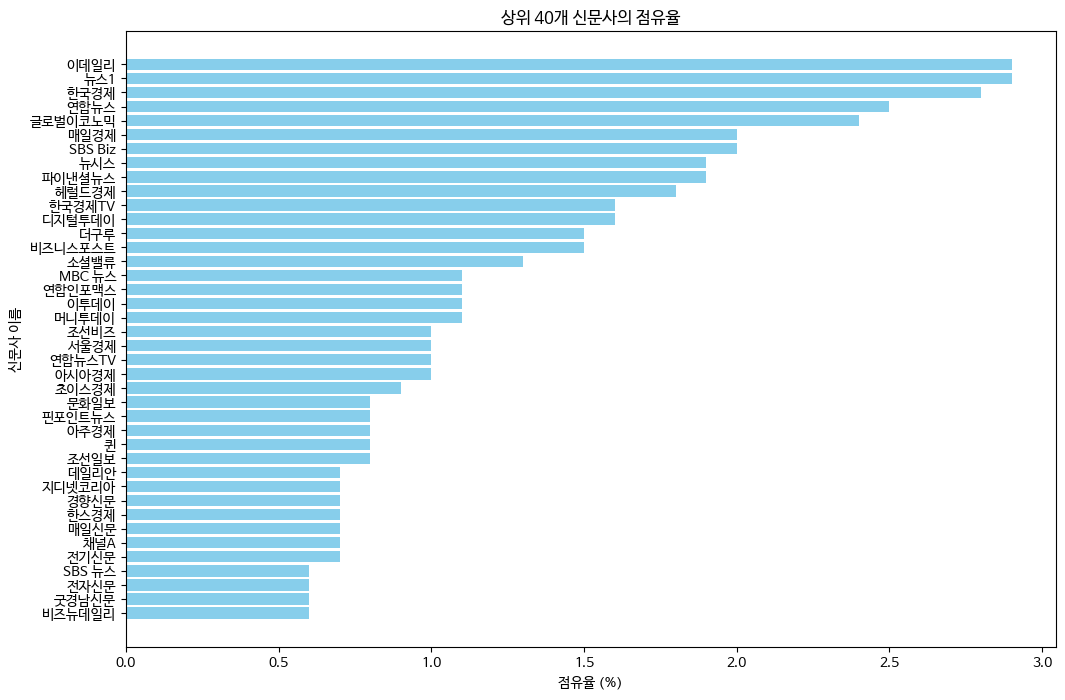

In [114]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm



# CSV 파일 경로
csv_file_path = "/content/테슬라_news_data_addpublish.csv"

# CSV 파일 읽기
df = pd.read_csv(csv_file_path)

# 총 기사 수 계산
total_articles = len(df)

# 총 신문사 수 계산
total_newspapers = df['신문사 이름'].nunique()

# 총 기사 수 출력
print(f"총 기사 수: {total_articles}")

# 총 신문사 수 출력
print(f"총 신문사 수: {total_newspapers}")

# 신문사별 기사 수 계산
news_counts = df['신문사 이름'].value_counts()

# 신문사별 점유율 계산
news_percentages = (news_counts / news_counts.sum()) * 100

# 신문사별 점유율 데이터프레임 생성
news_share_df = pd.DataFrame({
    '신문사 이름': news_counts.index,
    '기사 수': news_counts.values,
    '점유율 (%)': news_percentages.values
})

# 상위 40개 신문사만 선택
top_40_news_share_df = news_share_df.head(40)

# 상위 40개 신문사의 점유율 합계 계산
top_40_percentage_sum = top_40_news_share_df['점유율 (%)'].sum()

# 결과 출력
print(top_40_news_share_df)
print(f"\n상위 40개 신문사의 점유율 합계: {top_40_percentage_sum:.2f}%")

# 그래프 그리기
plt.figure(figsize=(12, 8))
plt.barh(top_40_news_share_df['신문사 이름'], top_40_news_share_df['점유율 (%)'], color='skyblue')
plt.xlabel('점유율 (%)')
plt.ylabel('신문사 이름')
plt.title('상위 40개 신문사의 점유율')
plt.gca().invert_yaxis()  # 큰 값이 상단에 오도록 y축 반전
plt.show()

# 필요시 CSV로 저장
# top_40_news_share_df.to_csv("/content/상위40_신문사별_점유율.csv", index=False, encoding='utf-8-sig')


In [149]:
pip install beautifulsoup4 requests pandas


In [127]:
import time
import requests
from bs4 import BeautifulSoup
import pandas as pd
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from webdriver_manager.chrome import ChromeDriverManager
from html import unescape
from datetime import datetime

# Pandas 옵션 설정: 긴 문자열도 모두 출력되도록 설정
pd.set_option('display.max_colwidth', None)

# 키워드를 입력하세요
keyword = input("키워드를 입력하세요: ")

# 조회 기간 옵션 설정
print("조회 기간을 선택하세요:")
print("1: 전체 기간")
print("2: 최근 1일")
print("3: 최근 1주")
print("4: 최근 1개월")
print("5: 최근 3개월")
print("6: 최근 6개월")
print("7: 최근 1년")
print("8: 사용자 지정 기간")

period_selection = input("선택: ")

# 기간에 따라 URL 파라미터 설정
if period_selection == "1":
    pd_param = "0"
    nso_param = "so:dd,p:all"
    ds = ""
    de = ""
elif period_selection == "2":
    pd_param = "4"
    nso_param = "so:dd,p:1d"
    ds = ""
    de = ""
elif period_selection == "3":
    pd_param = "1"
    nso_param = "so:dd,p:1w"
    ds = ""
    de = ""
elif period_selection == "4":
    pd_param = "2"
    nso_param = "so:dd,p:1m"
    ds = ""
    de = ""
elif period_selection == "5":
    pd_param = "3"
    nso_param = "so:dd,p:3m"
    ds = ""
    de = ""
elif period_selection == "6":
    pd_param = "6"
    nso_param = "so:dd,p:6m"
    ds = ""
    de = ""
elif period_selection == "7":
    pd_param = "5"
    nso_param = "so:dd,p:1y"
    ds = ""
    de = ""
elif period_selection == "8":
    # 사용자로부터 기간 입력받기
    start_date = input("시작 날짜를 입력하세요 (예: 2024.01.01): ")
    end_date = input("종료 날짜를 입력하세요 (예: 2024.08.25): ")
    pd_param = "3"  # 기간 검색으로 설정
    ds = start_date
    de = end_date
    nso_param = f"so:dd,p:from{start_date.replace('.', '')}to{end_date.replace('.', '')}"
else:
    print("올바른 옵션을 선택하세요.")
    exit()

# 조회 기준 옵션 설정
print("조회 기준을 선택하세요:")
print("1: 전체 기사")
print("2: 지면 기사")
print("3: 보도 자료")

criteria_selection = input("선택: ")

# 조회 기준에 따른 photo 파라미터 설정
if criteria_selection == "1":
    photo_param = "0"  # 전체 기사
elif criteria_selection == "2":
    photo_param = "3"  # 지면 기사
elif criteria_selection == "3":
    photo_param = "4"  # 보도 자료
else:
    print("올바른 옵션을 선택하세요.")
    exit()

# 네이버 뉴스 검색 결과 URL 생성
url = f"https://search.naver.com/search.naver?where=news&query={keyword}&sm=tab_opt&sort=0&photo={photo_param}&field=0&pd={pd_param}&ds={ds}&de={de}&docid=&related=0&mynews=0&office_type=0&office_section_code=0&news_office_checked=&nso={nso_param}&is_sug_officeid=0&office_category=0&service_area=0"

print(f"생성된 URL: {url}")

# Selenium WebDriver 설정 (헤드리스 모드)
chrome_options = Options()
chrome_options.add_argument("--headless")  # GUI 없는 모드에서 실행
chrome_options.add_argument("--no-sandbox")
chrome_options.add_argument("--disable-dev-shm-usage")

driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=chrome_options)
driver.get(url)

# 현재 날짜 (조회날짜) 가져오기
current_date = datetime.now().strftime('%Y-%m-%d')

# 기사 데이터 크롤링
data = []
seen_links = set()  # 중복 방지를 위한 링크 추적 집합

# 페이지 스크롤 반복 횟수 설정
max_scrolls = 100  # 이 값을 조정하여 스크롤을 더 많이 하거나 적게 할 수 있습니다.
scroll_pause_time = 2  # 스크롤 후 대기 시간
screen_height = driver.execute_script("return window.screen.height;")  # 화면 높이 가져오기
last_height = driver.execute_script("return document.body.scrollHeight")  # 스크롤의 마지막 위치

for scroll in range(max_scrolls):
    # 스크롤하기
    driver.execute_script(f"window.scrollTo(0, document.body.scrollHeight);")
    time.sleep(scroll_pause_time)

    # 페이지 소스를 가져와서 BeautifulSoup으로 파싱
    soup = BeautifulSoup(driver.page_source, 'html.parser')

    # 기사 수 계산 및 출력
    articles = soup.find_all('div', class_='news_area')
    print(f"스크롤 횟수 {scroll + 1}: 현재까지 {len(articles)}개의 기사를 발견했습니다.")

    if not articles:
        print("더 이상 기사가 없습니다.")
        break

    # 현재까지 로드된 기사의 정보 크롤링
    for article in articles:
        title_tag = article.find('a', class_='news_tit')
        title = title_tag['title'].strip() if title_tag else "제목 없음"
        link = title_tag['href'] if title_tag else "링크 없음"

        # 중복 기사 필터링
        if link in seen_links:
            continue
        seen_links.add(link)

        # HTML 엔티티 해제
        title = unescape(title)

        # HTML 태그가 포함된 경우에만 BeautifulSoup으로 파싱
        if '<' in title and '>' in title:
            title = BeautifulSoup(title, 'html.parser').get_text()  # HTML 태그 제거

        # 신문사 이름 추출
        press_tag = article.find('a', class_='info press')
        press = "신문사 정보 없음"
        if press_tag:
            press = press_tag.get_text(strip=True).replace("\n", "")

        # 발행일 추출 (class='info'인 <span> 태그)
        pub_date = "발행일 없음"
        pub_date_tag = article.find_all('span', class_='info')
        if pub_date_tag:
            for tag in pub_date_tag:
                if "전" in tag.get_text():
                    pub_date = tag.get_text(strip=True)
                    break

        # '바로가기' 링크 생성
        link_html = f'<a href="{link}" target="_blank">바로가기</a>'

        # 데이터 저장
        data.append({
            '조회날짜': current_date,
            '제목': title,
            '신문사': press,
            '발행일': pub_date,
            '링크': link_html
        })

    # 더 이상 새로운 기사가 로드되지 않는지 확인
    new_height = driver.execute_script("return document.body.scrollHeight")
    if new_height == last_height:
        print("더 이상 새로운 기사가 없습니다. 스크롤을 중단합니다.")
        break
    last_height = new_height

# 데이터 프레임으로 변환
df = pd.DataFrame(data)

# DataFrame을 HTML로 변환하여 링크가 포함된 형식으로 출력
df_html = df.to_html(escape=False)  # HTML 코드가 이스케이프되지 않도록 설정

# Jupyter Notebook에서 HTML로 출력
from IPython.core.display import display, HTML
display(HTML(df_html))

# 브라우저 종료
driver.quit()

# 결과를 CSV 파일로 저장
df.to_csv('크롤링_결과.csv', index=False, encoding='utf-8-sig')

print(f"총 {len(data)}개의 기사를 크롤링하여 저장했습니다.")


키워드를 입력하세요: 테슬라
조회 기간을 선택하세요:
1: 전체 기간
2: 최근 1일
3: 최근 1주
4: 최근 1개월
5: 최근 3개월
6: 최근 6개월
7: 최근 1년
8: 사용자 지정 기간
선택: 3
조회 기준을 선택하세요:
1: 전체 기사
2: 지면 기사
3: 보도 자료
선택: 2
생성된 URL: https://search.naver.com/search.naver?where=news&query=테슬라&sm=tab_opt&sort=0&photo=3&field=0&pd=1&ds=&de=&docid=&related=0&mynews=0&office_type=0&office_section_code=0&news_office_checked=&nso=so:dd,p:1w&is_sug_officeid=0&office_category=0&service_area=0
스크롤 횟수 1: 현재까지 20개의 기사를 발견했습니다.
스크롤 횟수 2: 현재까지 30개의 기사를 발견했습니다.
스크롤 횟수 3: 현재까지 40개의 기사를 발견했습니다.
스크롤 횟수 4: 현재까지 50개의 기사를 발견했습니다.
스크롤 횟수 5: 현재까지 60개의 기사를 발견했습니다.
스크롤 횟수 6: 현재까지 70개의 기사를 발견했습니다.
스크롤 횟수 7: 현재까지 80개의 기사를 발견했습니다.
스크롤 횟수 8: 현재까지 90개의 기사를 발견했습니다.
스크롤 횟수 9: 현재까지 100개의 기사를 발견했습니다.
스크롤 횟수 10: 현재까지 110개의 기사를 발견했습니다.
스크롤 횟수 11: 현재까지 120개의 기사를 발견했습니다.
스크롤 횟수 12: 현재까지 129개의 기사를 발견했습니다.
스크롤 횟수 13: 현재까지 129개의 기사를 발견했습니다.
더 이상 새로운 기사가 없습니다. 스크롤을 중단합니다.


,조회날짜,제목,신문사,발행일,링크
0,2024-08-25,국내 전기차 판매 1위 테슬라도 '활활' 꺼지지 않는 불안,부산일보언론사 선정,5일 전,바로가기
1,2024-08-25,[단독]카페 돌진 테슬라 60대 운전자 “원 페달 드라이빙 조작 실수”,동아일보언론사 선정,6일 전,바로가기
2,2024-08-25,"테슬라 또 리콜… ""반년간 미국서만 260만 대""",서울경제,3일 전,바로가기
3,2024-08-25,"국토부, 테슬라·기아등 10만3543대 리콜",전자신문,4일 전,바로가기
4,2024-08-25,"美, ‘고속도로 화재’ 테슬라 전기트럭 배터리 안전조사",문화일보,2일 전,바로가기
5,2024-08-25,"EU, 中생산 테슬라 관세 19%로 당초계획보다 10%P 하향 조정",매일경제,5일 전,바로가기
6,2024-08-25,"'M·N·A' 뺀 나머지는 주춤…M7, 실적 따라 희비 갈렸다",한국경제언론사 선정,2일 전,바로가기
7,2024-08-25,사람 수십명 뽑아 로봇에 매일 7시간 인간 행동 가르쳤다,조선일보언론사 선정,4일 전,바로가기
8,2024-08-25,[데스크 칼럼] 전기차 시장 ‘빙하기’ 오나,부산일보언론사 선정,4일 전,바로가기
9,2024-08-25,"""손떨림없이 24시간 근무""…'20년차 베테랑' 신입 정체 깜짝",한국경제언론사 선정,6시간 전,바로가기


총 113개의 기사를 크롤링하여 저장했습니다.


In [141]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

# 이미 크롤링된 데이터프레임을 사용
df = pd.read_csv('크롤링_결과.csv')

# 기사 작성일과 기자 이름을 저장할 리스트
article_dates = []
reporter_names = []



# 각 기사 링크에 접근하여 작성일 및 기자 이름 추출
for index, row in df.iterrows():
    link_html = row['링크']

    # BeautifulSoup을 사용해 링크에서 실제 URL 추출
    soup = BeautifulSoup(link_html, 'html.parser')
    article_url = soup.find('a')['href']  # 실제 URL 추출

    try:
        response = requests.get(article_url)
        soup = BeautifulSoup(response.content, 'html.parser')

        # 여러 패턴을 시도하여 작성일 추출
        article_date = None
        reporter_name = None

        # 작성일 추출 패턴
        # 패턴 1: <meta property="article:published_time">
        date_tag = soup.find('meta', {'property': 'article:published_time'})
        if date_tag:
            article_date = date_tag.get('content', '').split('T')[0]

        # 패턴 2: <div class="byline"> 또는 <em> 태그 내부의 "입력"
        if not article_date:
            date_tag = soup.find('div', class_='byline')
            if date_tag:
                date_text = date_tag.get_text()
                if "입력" in date_text:
                    article_date = date_text.strip().split('입력 :')[1].split()[0]

        # 패턴 3: <ul class="view_info_date"> 내부의 "입력"
        if not article_date:
            date_tag = soup.find('ul', class_='view_info_date')
            if date_tag:
                date_text = date_tag.get_text()
                if "입력" in date_text:
                    article_date = date_text.strip().split('입력 ')[1].split()[0]

        # 패턴 4: <span class="upDate"> 내부의 "업데이트"
        if not article_date:
            date_tag = soup.find('span', class_='upDate')
            if date_tag:
                article_date = date_tag.get_text().strip().split('업데이트')[1].split()[0]

        # 패턴 5: <li class="ArticleDetailView_dateListItem__mRc3d"> 내부의 "등록"
        if not article_date:
            date_tag = soup.find('li', class_='ArticleDetailView_dateListItem__mRc3d')
            if date_tag:
                date_text = date_tag.get_text()
                if "등록" in date_text:
                    article_date = date_tag.find('span').get_text().strip()

        # 패턴 6: <span class="inputDate btnToggle"> 내부의 "입력"
        if not article_date:
            date_tag = soup.find('span', class_='inputDate')
            if date_tag and "입력" in date_tag.get_text():
                article_date = date_tag.get_text().strip().split('입력')[1].strip()

        # 패턴 7: <div class="article_info"> 또는 <span class="url_txt"> 내부의 "입력"
        if not article_date:
            date_tag = soup.find('div', class_='article_info')
            if date_tag:
                date_text = date_tag.get_text()
                if "입력" in date_text:
                    article_date = date_text.strip().split('입력:')[1].split()[0]

        # 패턴 8: <div class="art_info"> 내부의 <em> 태그에서 "입력"
        if not article_date:
            date_tag = soup.find('div', class_='art_info')
            if date_tag:
                em_tag = date_tag.find('em')
                if em_tag and "입력" in em_tag.get_text():
                    article_date = em_tag.get_text().strip().split('입력 :')[1].split()[0]

         # 기자 이름 추출 패턴
        # 패턴 1: <div class="article_info">
        if not reporter_name:
            reporter_tag = soup.find('div', class_='article_info')
            if reporter_tag:
                em_tag = reporter_tag.find_all('em')
                for tag in em_tag:
                    text = tag.get_text().strip()
                    if ("기자" in text or "특파원" in text) and len(text) < 50:
                        reporter_name = text
                        break

        # 패턴 2: <span class="author"><a>
        if not reporter_name:
            reporter_tag = soup.find('span', class_='author')
            if reporter_tag and reporter_tag.find('a'):
                text = reporter_tag.find('a').get_text().strip()
                if "기자" in text and len(text) < 50:
                    reporter_name = text

        # 패턴 3: <article class="press-info">
        if not reporter_name:
            reporter_tag = soup.find('article', class_='press-info')
            if reporter_tag:
                text = reporter_tag.get_text().strip()
                if "기자" in text and len(text.split()[0]) < 20:
                    reporter_name = text.split()[0] + " 기자"

        # 패턴 4 & 5: <div class="reporter_profile">
        if not reporter_name:
            reporter_tag = soup.find('div', class_='reporter_profile')
            if reporter_tag:
                strong_tag = reporter_tag.find('strong')
                if strong_tag:
                    text = strong_tag.get_text().strip()
                    if "기자" in text or "특파원" in text:
                        reporter_name = text

        # 패턴 6: <div class="writer">
        if not reporter_name:
            reporter_tag = soup.find('div', class_='writer')
            if reporter_tag:
                text = reporter_tag.get_text().strip()
                if "기자" in text and len(text) < 50:
                    reporter_name = text

        # 패턴 7: <div class="view_info_editor">
        if not reporter_name:
            reporter_tag = soup.find('div', class_='view_info_editor')
            if reporter_tag and reporter_tag.find('a'):
                text = reporter_tag.find('a').get_text().strip()
                if "기자" in text and len(text) < 50:
                    reporter_name = text

        # 패턴 8: <li class="name">
        if not reporter_name:
            name_list = soup.find_all('li', class_='name')
            for name in name_list:
                text = name.get_text().strip()
                if "기자" in text and len(text) < 50:
                    reporter_name = text
                    break

        # 패턴 9: <span class="name"><a>
        if not reporter_name:
            reporter_tag = soup.find('span', class_='name')
            if reporter_tag and reporter_tag.find('a'):
                text = reporter_tag.find('a').get_text().strip()
                if "기자" in text and len(text) < 50:
                    reporter_name = text

        # 패턴 10: 이메일 패턴 (예: "20ki@heraldcorp.com = 이영기 기자")
        if not reporter_name:
            reporter_tag = soup.find(lambda tag: tag.name == 'p' and "@" in tag.get_text())
            if reporter_tag:
                text = reporter_tag.get_text().strip().split('=')[-1].strip()
                if "기자" in text and len(text) < 50:
                    reporter_name = text

        # 패턴 11: <div class="name-box">
        if not reporter_name:
            reporter_tag = soup.find('div', class_='name-box')
            if reporter_tag:
                text = reporter_tag.find('span', class_='nm').get_text().strip()
                if len(text) < 50:
                    reporter_name = text + " 기자"

        # 패턴 12: <div class="author-list">
        if not reporter_name:
            reporter_tag = soup.find('div', class_='author-list')
            if reporter_tag:
                text = reporter_tag.get_text().strip().split("기자")[0].strip()
                if len(text) < 50:
                    reporter_name = text + " 기자"

        # 패턴 13: <p class="writer addByline">
        if not reporter_name:
            reporter_tag = soup.find('p', class_='writer addByline')
            if reporter_tag:
                text = reporter_tag.get_text().strip()
                if "기자" in text and len(text) < 50:
                    reporter_name = text

        # 패턴 14: <div class="byline btn_absolute">
        if not reporter_name:
            byline_tags = soup.find_all('div', class_='byline btn_absolute')
            for byline in byline_tags:
                links = byline.find_all('a')
                for link in links:
                    text = link.get_text().strip()
                    if "기자" in text and len(text) < 50:
                        reporter_name = text
                        break

        # 패턴 15: <a class="article-byline__author">
        if not reporter_name:
            reporter_tag = soup.find('a', class_='article-byline__author')
            if reporter_tag:
                text = reporter_tag.get_text().strip()
                if "기자" in text and len(text) < 50:
                    reporter_name = text

        # 패턴 16: 단순 텍스트 패턴
        if not reporter_name:
            reporter_tag = soup.find(lambda tag: "기자" in tag.get_text())
            if reporter_tag:
                text = reporter_tag.get_text().strip()
                if "기자" in text and len(text) < 50:
                    reporter_name = text

        # 날짜를 찾을 수 없었을 경우 처리
        if not article_date:
            article_date = "날짜를 찾을 수 없음"

        # 기자 이름을 찾을 수 없었을 경우 처리
        if not reporter_name:
            reporter_name = "기자 이름을 찾을 수 없음"

        article_dates.append(article_date)
        reporter_names.append(reporter_name)
        print(f"{index + 1}번째 기사 작성일: {article_date}, 기자 이름: {reporter_name}")

    except Exception as e:
        print(f"오류 발생: {e}")
        article_dates.append("오류 발생")
        reporter_names.append("오류 발생")

# 데이터프레임에 새로운 열로 기사 작성일 및 기자 이름 추가
df['기사작성일'] = article_dates
df['기자이름'] = reporter_names

# 수정된 데이터프레임을 CSV로 저장
df.to_csv('크롤링_결과_작성일_기자이름.csv', index=False, encoding='utf-8-sig')

print("기사 작성일 및 기자 이름 정보가 포함된 CSV 파일이 저장되었습니다.")

1번째 기사 작성일: 2024-08-20, 기자 이름: 배동진 기자 djbae@busan.com
2번째 기사 작성일: 2024-08-19, 기자 이름: 이채완 기자
3번째 기사 작성일: 2024-08-22, 기자 이름: 실리콘밸리=윤민혁 특파원
4번째 기사 작성일: 2024-08-21, 기자 이름: 기자 이름을 찾을 수 없음
5번째 기사 작성일: 2024-08-23, 기자 이름: 기자 이름을 찾을 수 없음
6번째 기사 작성일: 2024-08-20, 기자 이름: 기자 이름을 찾을 수 없음
7번째 기사 작성일: 2024-08-23, 기자 이름: 양병훈 기자
8번째 기사 작성일: 날짜를 찾을 수 없음, 기자 이름: 기자 이름을 찾을 수 없음
9번째 기사 작성일: 2024-08-21, 기자 이름: 배동진 기자 djbae@busan.com
10번째 기사 작성일: 2024-08-25, 기자 이름: 김형규 기자
11번째 기사 작성일: 20240819, 기자 이름: 정우태 기자
12번째 기사 작성일: 날짜를 찾을 수 없음, 기자 이름: 기자 이름을 찾을 수 없음
13번째 기사 작성일: 2024-08-19, 기자 이름: 한재희 기자
14번째 기사 작성일: 2024-08-21, 기자 이름: 최종근 기자
15번째 기사 작성일: 2024-08-20, 기자 이름: 한재희 기자
16번째 기사 작성일: 2024-08-20, 기자 이름: 김일규 기자
17번째 기사 작성일: 2024-08-20, 기자 이름: 박종원 기자,


18번째 기사 작성일: 2024-08-18, 기자 이름: 기자 이름을 찾을 수 없음
19번째 기사 작성일: 2024-08-21, 기자 이름: 기자 이름을 찾을 수 없음
20번째 기사 작성일: 2024-08-20, 기자 이름: 기자 이름을 찾을 수 없음
21번째 기사 작성일: 2024-08-21, 기자 이름: 조영빈 기자
22번째 기사 작성일: 2024-08-19, 기자 이름: 최선욱·고석현 기자  isotope@joongang.co.kr
23번째 기사 작성일: 2024-08-19, 기자 이름: 박일근 기자
24번째 기사 작성일: 2024-08-23, 기자 이름: 기자 이름을 찾을 수 없음
25번째 기사 작성일: 2024-08-22, 기자 이름: 기자 이름을 찾을 수 없음
26번째 기사 작성일: 날짜를 찾을 수 없음, 기자 이름: 기자 이름을 찾을 수 없음
27번째 기사 작성일: 2024-08-19, 기자 이름: 기자 이름을 찾을 수 없음
28번째 기사 작성일: 2024-08-19, 기자 이름: 이우림 기자   yi.woolim@joongang.co.kr
29번째 기사 작성일: 2024-08-21, 기자 이름: 강경주 기자
30번째 기사 작성일: 2024-08-21, 기자 이름: 이완기 기자
31번째 기사 작성일: 2024-08-19, 기자 이름: 기자 이름을 찾을 수 없음
32번째 기사 작성일: 2024-08-21, 기자 이름: 이서희 기자
33번째 기사 작성일: 2024-08-20, 기자 이름: 기자 이름을 찾을 수 없음
34번째 기사 작성일: 2024-08-25, 기자 이름: 김인엽 기자
35번째 기사 작성일: 2024-08-25, 기자 이름: 기자 이름을 찾을 수 없음
36번째 기사 작성일: 2024-08-25, 기자 이름: 기자 이름을 찾을 수 없음
37번째 기사 작성일: 2024-08-25, 기자 이름: 나수지 기자
38번째 기사 작성일: 2024-08-24, 기자 이름: 이상무  기자 allclear@hankookilbo.com
39번째 기사 작성일

50번째 기사 작성일: 2024-08-21, 기자 이름: 기자 이름을 찾을 수 없음
51번째 기사 작성일: 2024-08-21, 기자 이름: 권준호 기자,
52번째 기사 작성일: 날짜를 찾을 수 없음, 기자 이름: 기자 이름을 찾을 수 없음
53번째 기사 작성일: 2024-08-23, 기자 이름: 기자 이름을 찾을 수 없음
54번째 기사 작성일: 2024-08-20, 기자 이름: 기자 이름을 찾을 수 없음
55번째 기사 작성일: 2024-08-21, 기자 이름: 이수연 기자
56번째 기사 작성일: 2024-08-19, 기자 이름: 최경민 기자
57번째 기사 작성일: 2024-08-21, 기자 이름: 기자 이름을 찾을 수 없음
58번째 기사 작성일: 2024-08-23, 기자 이름: 기자 이름을 찾을 수 없음
59번째 기사 작성일: 2024-08-20, 기자 이름: 기자 이름을 찾을 수 없음
60번째 기사 작성일: 날짜를 찾을 수 없음, 기자 이름: 권지담 기자 gonji@hani.co.kr
61번째 기사 작성일: 2024-08-20, 기자 이름: 기자 이름을 찾을 수 없음
62번째 기사 작성일: 2024-08-20, 기자 이름: 기자 이름을 찾을 수 없음
63번째 기사 작성일: 2024-08-21, 기자 이름: 기자 이름을 찾을 수 없음
64번째 기사 작성일: 2024-08-22, 기자 이름: 기자 이름을 찾을 수 없음
65번째 기사 작성일: 2024-08-20, 기자 이름: 윤성민 기자 yoon.sungmin@joongang.co.kr
66번째 기사 작성일: 2024-08-19, 기자 이름: 기자 이름을 찾을 수 없음
67번째 기사 작성일: 날짜를 찾을 수 없음, 기자 이름: 김미나 기자 mina@hani.co.kr
68번째 기사 작성일: 2024-08-22, 기자 이름: 김재형 기자
69번째 기사 작성일: 2024-08-20, 기자 이름: 홍석호 기자
70번째 기사 작성일: 2024-08-19, 기자 이름: 송이라 기자
71번째 기사 작성일: 2024-08

In [142]:
import pandas as pd

# 이미 크롤링된 데이터프레임을 사용
df = pd.read_csv('크롤링_결과.csv')

# 신문사별 그룹화
grouped = df.groupby('신문사')

# 대표 기사 링크 추출 (각 신문사별로 1개의 기사 링크를 가져옴)
representative_links = grouped['링크'].first().reset_index()

# 대표 링크 출력
print("대표 기사 링크 목록:")
print(representative_links)

# 대표 링크를 CSV로 저장
representative_links.to_csv('대표_기사_링크.csv', index=False, encoding='utf-8-sig')

print("대표 기사 링크가 포함된 CSV 파일이 저장되었습니다.")



대표 기사 링크 목록:
             신문사  \
0           경향신문   
1     경향신문언론사 선정   
2           국민일보   
3           대전일보   
4           동아일보   
5     동아일보언론사 선정   
6         디지털타임스   
7           매일경제   
8     매일경제언론사 선정   
9           매일신문   
10         머니투데이   
11   머니투데이언론사 선정   
12          문화일보   
13    부산일보언론사 선정   
14          서울경제   
15    서울경제언론사 선정   
16    서울신문언론사 선정   
17          세계일보   
18    세계일보언론사 선정   
19         아시아경제   
20   아시아경제언론사 선정   
21          이데일리   
22    이데일리언론사 선정   
23          전자신문   
24    전자신문언론사 선정   
25          조선일보   
26    조선일보언론사 선정   
27          중앙일보   
28    중앙일보언론사 선정   
29        파이낸셜뉴스   
30  파이낸셜뉴스언론사 선정   
31           한겨레   
32     한겨레언론사 선정   
33          한국경제   
34    한국경제언론사 선정   
35          한국일보   
36    한국일보언론사 선정   
37         헤럴드경제   

                                                                                                                                                                                  링크  
0                      

In [147]:
import pandas as pd

# 이미 크롤링된 데이터프레임을 사용
df = pd.read_csv('/content/크롤링_결과_작성일_기자이름.csv')

# '기자 이름을 찾을 수 없음'에 해당하는 행만 필터링
missing_reporter_names_df = df[df['기자이름'] == "기자 이름을 찾을 수 없음"]

# 필터링된 결과 출력
print("기자 이름을 찾을 수 없는 기사 목록:")
print(missing_reporter_names_df)

# 결과를 CSV로 저장
missing_reporter_names_df.to_csv('기자이름_찾을수없는_기사.csv', index=False, encoding='utf-8-sig')
print("기자 이름을 찾을 수 없는 기사 목록이 '기자이름_찾을수없는_기사.csv' 파일로 저장되었습니다.")


기자 이름을 찾을 수 없는 기사 목록:
           조회날짜                                             제목          신문사  \
3    2024-08-25                       국토부, 테슬라·기아등 10만3543대 리콜         전자신문   
4    2024-08-25                 美, ‘고속도로 화재’ 테슬라 전기트럭 배터리 안전조사         문화일보   
5    2024-08-25          EU, 中생산 테슬라 관세 19%로 당초계획보다 10%P 하향 조정         매일경제   
7    2024-08-25                사람 수십명 뽑아 로봇에 매일 7시간 인간 행동 가르쳤다   조선일보언론사 선정   
11   2024-08-25                       [만물상] 원전 거인 ‘웨스팅하우스’의 추락         조선일보   
17   2024-08-25      체첸 공화국 독재자 “고맙다! 머스크… 총탑 단 사이버트럭 우크라 전...   서울신문언론사 선정   
18   2024-08-25                          송파서도 테슬라 돌진, 차량 7대 파손         동아일보   
19   2024-08-25                           현대차그룹 전기차 美점유율 첫 10%         매일경제   
23   2024-08-25              국민연금, 6개월새 20조 벌었다…미국 주식 뭐 샀나 봤더니   이데일리언론사 선정   
24   2024-08-25           AI 다음은 로봇株 애플·삼전 주목을 [MBN GOLD 시황저격]         매일경제   
25   2024-08-25                     [한삼희의 환경칼럼] 전기차를 위한 약간의 변호         조선일보   
26   2024-08-25              보

총 기사 수: 113
총 신문사 수: 38
          신문사 이름  기사 수   점유율 (%)
0     한국경제언론사 선정     9  7.964602
1           매일경제     8  7.079646
2           서울경제     8  7.079646
3     동아일보언론사 선정     7  6.194690
4           동아일보     6  5.309735
5    아시아경제언론사 선정     5  4.424779
6           조선일보     5  4.424779
7         파이낸셜뉴스     5  4.424779
8           한국경제     5  4.424779
9           중앙일보     5  4.424779
10    이데일리언론사 선정     4  3.539823
11         머니투데이     3  2.654867
12         헤럴드경제     3  2.654867
13          국민일보     3  2.654867
14          한국일보     3  2.654867
15     한겨레언론사 선정     2  1.769912
16          이데일리     2  1.769912
17    세계일보언론사 선정     2  1.769912
18           한겨레     2  1.769912
19    한국일보언론사 선정     2  1.769912
20    부산일보언론사 선정     2  1.769912
21         아시아경제     2  1.769912
22    경향신문언론사 선정     2  1.769912
23    서울신문언론사 선정     2  1.769912
24  파이낸셜뉴스언론사 선정     2  1.769912
25    조선일보언론사 선정     2  1.769912
26   머니투데이언론사 선정     1  0.884956
27          대전일보     1  0.884956
28          경향신문   

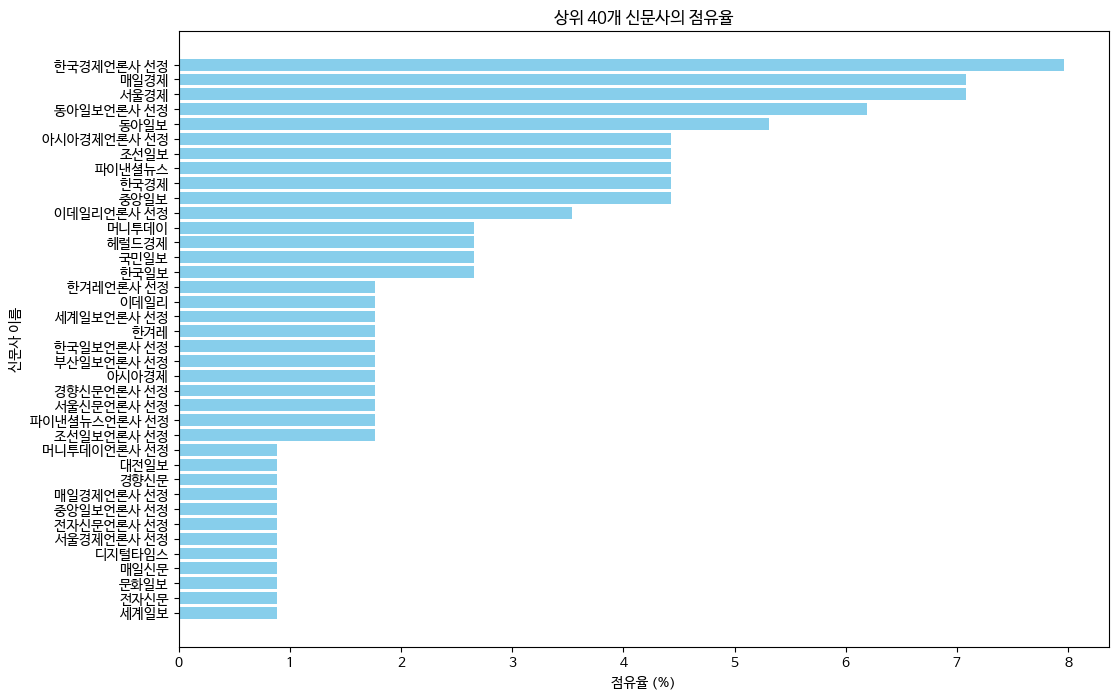

In [148]:
import pandas as pd
import matplotlib.pyplot as plt

# CSV 파일 경로
csv_file_path = "/content/크롤링_결과_작성일_기자이름.csv"

# CSV 파일 읽기
df = pd.read_csv(csv_file_path)

# 총 기사 수 계산
total_articles = len(df)

# 총 신문사 수 계산
total_newspapers = df['신문사'].nunique()

# 총 기사 수 출력
print(f"총 기사 수: {total_articles}")

# 총 신문사 수 출력
print(f"총 신문사 수: {total_newspapers}")

# 신문사별 기사 수 계산
news_counts = df['신문사'].value_counts()

# 신문사별 점유율 계산
news_percentages = (news_counts / news_counts.sum()) * 100

# 신문사별 점유율 데이터프레임 생성
news_share_df = pd.DataFrame({
    '신문사 이름': news_counts.index,
    '기사 수': news_counts.values,
    '점유율 (%)': news_percentages.values
})

# 상위 40개 신문사만 선택
top_40_news_share_df = news_share_df.head(40)

# 상위 40개 신문사의 점유율 합계 계산
top_40_percentage_sum = top_40_news_share_df['점유율 (%)'].sum()

# 결과 출력
print(top_40_news_share_df)
print(f"\n상위 40개 신문사의 점유율 합계: {top_40_percentage_sum:.2f}%")

# 그래프 그리기
plt.figure(figsize=(12, 8))
plt.barh(top_40_news_share_df['신문사 이름'], top_40_news_share_df['점유율 (%)'], color='skyblue')
plt.xlabel('점유율 (%)')
plt.ylabel('신문사 이름')
plt.title('상위 40개 신문사의 점유율')
plt.gca().invert_yaxis()  # 큰 값이 상단에 오도록 y축 반전
plt.show()

# 필요시 CSV로 저장
# top_40_news_share_df.to_csv("/content/상위40_신문사별_점유율.csv", index=False, encoding='utf-8-sig')
